# Big Data Coursework - Questions

## Data Processing and Machine Learning in the Cloud

This is the **INM432 Big Data coursework 2024**.
This coursework contains extended elements of **theory** and **practice**, mainly around parallelisation of tasks withSpark and a bit about parallel training using TensorFlow.   

## Code and Report

Your tasks parallelization of tasks in PySpark, extension, evaluation, and theoretical reflection.
Please complete and submit the **coding tasks** in a copy of **this notebook**.
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that **your code contains comments** on its **stucture** and explanations of its **purpose**.

Provide also a **report** with the **textual answers in a separate document**.  
Include **screenshots** from the Google Cloud web interface (don't use the SCREENSHOT function that Google provides, but take a picture of the graphs you see for the VMs) and result tables, as well as written text about the analysis.



## Submission

Download and submit **your version of this notebook** as an **.ipynb** file and also submit a **shareable link** to your notebook on Colab in your report (created with the Colab 'Share' function) (**and don’t change the online version after submission**).

Further, provide your **report as a PDF document**. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  


Please also submit **a PDF of your Jupyter notebook**.

## Introduction and Description

This coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras.
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner.
The course is based on Tensorflow for data processing and MachineLearning.
Tensorflow's data processing approach is somewhat similar to that of Spark, but you don't need to study Tensorflow, just make sure you understand the high-level structure.  
What we will do here is **parallelising** **pre-processing**, and **measuring** performance, and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**.

This coursework contains **3 sections**.

### Section 0

This section just contains some necessary code for setting up the environment. It has no tasks for you (but do read the code and comments).

### Section 1
Section 1 is about preprocessing a set of image files.
We will work with a public dataset “Flowers” (3600 images, 5 classes).
This is not a vast dataset, but it keeps the tasks more manageable for development and you can scale up later, if you like.

In **'Getting Started'** we will work through the data preprocessing code from *Fast and Lean Data Science* which uses TensorFlow's `tf.data` package.
There is no task for you here, but you will need to re-use some of this code later.

In **Task 1** you will **parallelise the data preprocessing in Spark**, using Google Cloud (GC) Dataproc.
This involves adapting the code from 'Getting Started' to use Spark and running it in the cloud.

### Section 2
In **Section 2** we are going to **measure the speed of reading data** in the cloud. In **Task  2** we will **paralellize the measuring** of different configurations **using Spark**.

### Section 3

This section is about the theoretical discussion, based on one paper, in **Task 3**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis.

The **tasks** are **mostly independent** of each other. The later tasks can mostly be addressed without needing the solution to the earlier ones.  

# Section 0: Set-up

As usual, you need to run the **imports and authentication every time you work with this notebook**. Use the **local Spark** installation for development before you send jobs to the cloud.

Read through this section once and **fill in the project ID the first time**, then you can just step straight throught this at the beginning of each session - except for the two authentication cells.

### Imports

We import some **packages that will be needed throughout**.
For the **code that runs in the cloud**, we will need **separate import sections** that will need to be partly different from the one below.


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle

Tensorflow version 2.15.0


### Cloud and Drive authentication

This is for **authenticating with with GCS Google Drive**, so that we can create and use our own buckets and access Dataproc and AI-Platform.

This section **starts with the two interactive authentications**.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW` thay you can use for this work.
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the GCS to enable access to Dataproc and AI-Platform.

In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to **create a new Google Cloud project** for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell. Also **enable billing** and the **Compute, Storage and Dataproc** APIs like we did during the labs.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit.
This way we don't have to specify this information every time we access the cloud.  

In [ ]:
PROJECT = 'big-data-project-420514'  ### USE YOUR GOOGLE CLOUD PROJECT ID HERE. ###
!gcloud config set project $PROJECT
REGION = 'us-central1'
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION

!gcloud config list # show some information

With the cell below, we **create a storage bucket** that we will use later for **global storage**.
If the bucket exists you will see a "ServiceException: 409 ...", which does not cause any problems.
**You must create your own bucket to have write access.**

In [5]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-project-420514-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-project-420514-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [6]:
#@title Utility functions for image display **[RUN THIS TO ACTIVATE]** { display-mode: "form" }
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(str(label.numpy()), fontsize=16)
    # plt.title(label.numpy().decode(), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  classes = np.argmax(predictions, axis=-1)
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(classes[i], labels[i])
    subplot = display_one_flower(image, title, subplot, not correct)
    if i >= 8:
      break;

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()


### Install Spark locally for quick testing

You can use the cell below to **install Spark locally on this Colab VM** (like in the labs), to do quicker small-scale interactive testing. Using Spark in the cloud with **Dataproc is still required for the final version**.


In [7]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq >> /dev/null # send any output to null device
!tar -xzf "/content/drive/My Drive/Big_Data/data/spark/spark-3.5.0-bin-hadoop3.tgz" # unpack

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
3.5.0


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning.
We first look at a ready-made solution using Tensorflow and then we build a implement the same process with Spark.
The tasks are about **parallelisation** and **analysis** the performance of the cloud implementations.

## 1.1 Getting started

In this section, we get started with the data pre-processing. The code is based on lecture 3 of the 'Fast and Lean Data Science' course.

**This code is using the TensorFlow** `tf.data` package, which supports map functions, similar to Spark. Your **task** will be to **re-implement the same approach in Spark**.  


We start by **setting some variables for the *Flowers* dataset**.

In [8]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
PARTITIONS = 16 # no of partitions we will use later
TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data

We **read the image files** from the public GCS bucket that contains the *Flowers* dataset.
**TensorFlow** has **functions** to execute glob patterns that we use to calculate the the number of images in total and per partition (rounded up as we cannont deal with parts of images).

In [9]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) # number of images
partition_size = math.ceil(1.0 * nb_images / PARTITIONS) # images per partition (float)
print("GCS_PATTERN matches {} images, to be divided into {} partitions with up to {} images each.".format(nb_images, PARTITIONS, partition_size))


GCS_PATTERN matches 3670 images, to be divided into 16 partitions with up to 230 images each.


### Map functions

In order to read use the images for learning, they need to be **preprocessed** (decoded, resized, cropped, and potentially recompressed).
Below are **map functions** for these steps.
You **don't need to study** the **internals of these functions** in detail.

In [ ]:
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

With `tf.data`, we can apply decoding and resizing as map functions.

In [ ]:
dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
dsetResized = dsetDecoded.map(resize_and_crop_image)

We can also look at some images using the image display function defined above (the one with the hidden code).

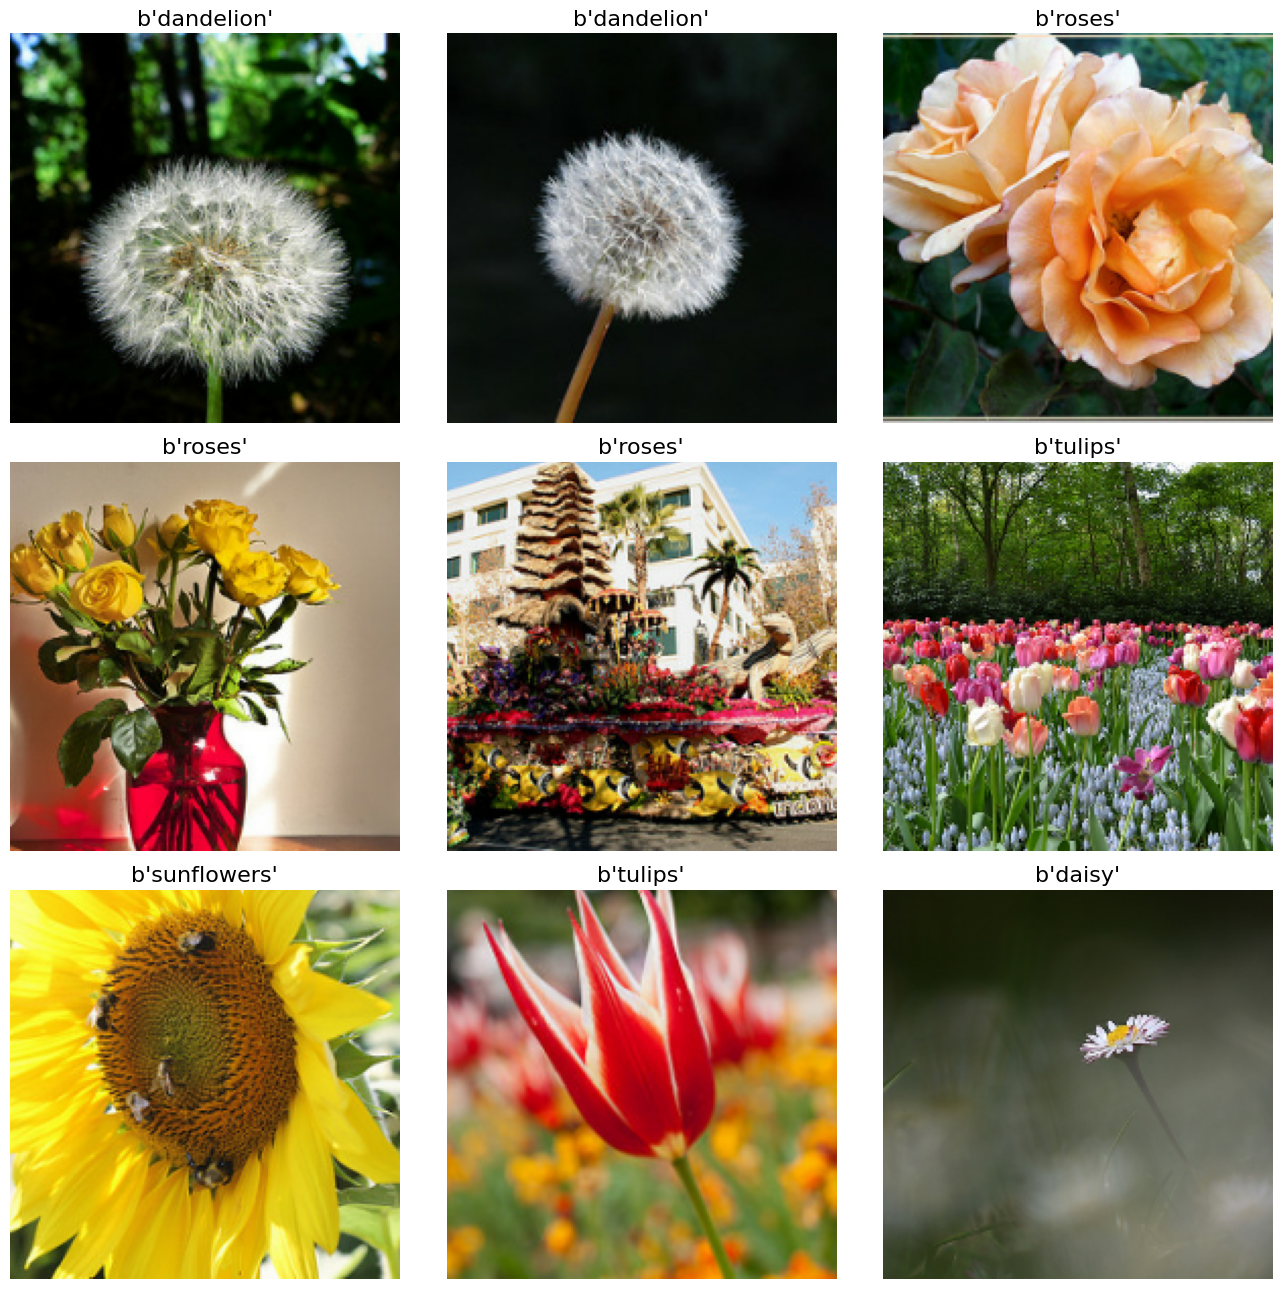

In [ ]:
display_9_images_from_dataset(dsetResized)

Now, let's test continuous reading from the dataset. We can see that reading the first 100 files already takes some time.

In [ ]:
sample_set = dsetResized.batch(10).take(10) # take 10 batches of 10 images for testing
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['roses', 'dandelion', 'roses', 'sunflowers', 'sunflowers', 'tulips', 'tulips', 'tulips', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'dandelion', 'daisy', 'dandelion', 'sunflowers', 'tulips', 'daisy', 'dandelion', 'daisy', 'tulips'])
Image batch shape (10, 192, 192, 3), ['roses', 'daisy', 'daisy', 'tulips', 'tulips', 'roses', 'dandelion', 'sunflowers', 'dandelion', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['tulips', 'sunflowers', 'daisy', 'tulips', 'roses', 'roses', 'dandelion', 'daisy', 'daisy', 'daisy'])
Image batch shape (10, 192, 192, 3), ['sunflowers', 'tulips', 'tulips', 'daisy', 'daisy', 'roses', 'tulips', 'roses', 'roses', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['dandelion', 'sunflowers', 'dandelion', 'tulips', 'roses', 'sunflowers', 'roses', 'sunflowers', 'sunflowers', 'sunflowers'])
Image batch shape (10, 192, 192, 3), ['tulips', 'dandelion', 'sunflowers', 'roses', 'sunflowers', 'sunflow

## 1.2 Improving Speed

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images
By **compressing** the images in the **reduced resolution** we save on the size.
This **costs some CPU time** upfront, but **saves network and disk bandwith**, especially when the data are **read multiple times**.


In [ ]:
# This is a quick test to get an idea how long recompressions takes.
dataset4 = dsetResized.map(recompress_image)
test_set = dataset4.batch(10).take(10)
for image, label in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (10,), ['dandelion', 'tulips', 'daisy', 'daisy', 'daisy', 'sunflowers', 'sunflowers', 'tulips', 'roses', 'daisy'])
Image batch shape (10,), ['sunflowers', 'sunflowers', 'daisy', 'roses', 'roses', 'daisy', 'daisy', 'roses', 'tulips', 'tulips'])
Image batch shape (10,), ['sunflowers', 'dandelion', 'dandelion', 'dandelion', 'dandelion', 'roses', 'tulips', 'tulips', 'daisy', 'sunflowers'])
Image batch shape (10,), ['roses', 'dandelion', 'roses', 'sunflowers', 'sunflowers', 'dandelion', 'daisy', 'sunflowers', 'tulips', 'tulips'])
Image batch shape (10,), ['tulips', 'daisy', 'sunflowers', 'tulips', 'dandelion', 'sunflowers', 'roses', 'roses', 'dandelion', 'tulips'])
Image batch shape (10,), ['sunflowers', 'roses', 'dandelion', 'roses', 'sunflowers', 'roses', 'daisy', 'dandelion', 'dandelion', 'dandelion'])
Image batch shape (10,), ['daisy', 'tulips', 'dandelion', 'daisy', 'daisy', 'dandelion', 'sunflowers', 'tulips', 'dandelion', 'roses'])
Image batch shape (10,), ['tulips'

### Write the dataset to TFRecord files

By writing **multiple preprocessed samples into a single file**, we can make further speed gains.
We distribute the data over **partitions** to facilitate **parallelisation** when the data are used.
First we need to **define a location** where we want to put the file.

In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket.

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. For convenience I have commented out the call to `write_tfrecords` at the end of the next cell. You don't need to run it (it takes some time), but you'll need to use the code below later (but there is no need to study it in detail).

There is a **ready-made pre-processed data** versions available here:
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for testing.

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size): # write the images to files.
    print("Writing TFRecords")
    tt0 = time.time()
    filenames = tf.data.Dataset.list_files(GCS_PATTERN)
    print(filenames)
    dataset1 = filenames.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    dataset3 = dataset2.map(recompress_image)
    dataset4 = dataset3.batch(partition_size) # partitioning: there will be one "batch" of images per file
    for partition, (image, label) in enumerate(dataset4):
        # batch size used as partition size here
        partition_size = image.numpy().shape[0]
        # good practice to have the number of records in the filename
        filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(partition, partition_size)
        # You need to change GCS_OUTPUT to your own bucket to actually create new files
        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(partition_size):
                example = to_tfrecord(out_file,
                                    image.numpy()[i], # re-compressed image: already a byte string
                                    label.numpy()[i] #
                                    )
                out_file.write(example.SerializeToString())
        print("Wrote file {} containing {} records".format(filename, partition_size))
    print("Total time: "+str(time.time()-tt0))

# write_tfrecords(GCS_PATTERN,GCS_OUTPUT,partition_size) # uncomment to run this cell

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
# remove the line above to use your own files that you generated above

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

Let's have a look **if reading from the TFRecord** files is **quicker**.

In [ ]:
batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['1', '3', '3', '1', '1', '2', '4', '3', '4', '3'])
Image batch shape (10, 192, 192, 3), ['3', '0', '3', '4', '2', '2', '3', '2', '0', '3'])
Image batch shape (10, 192, 192, 3), ['4', '4', '4', '1', '3', '2', '4', '4', '4', '3'])
Image batch shape (10, 192, 192, 3), ['1', '3', '4', '1', '1', '4', '2', '2', '3', '2'])
Image batch shape (10, 192, 192, 3), ['0', '4', '3', '4', '0', '1', '2', '1', '2', '0'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '2', '0', '0', '1', '4', '3', '1'])
Image batch shape (10, 192, 192, 3), ['1', '2', '0', '2', '3', '4', '2', '1', '1', '0'])
Image batch shape (10, 192, 192, 3), ['0', '1', '1', '3', '1', '0', '1', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '1', '1', '2', '0', '3', '0', '1'])
Image batch shape (10, 192, 192, 3), ['0', '0', '1', '1', '1', '0', '1', '4', '3', '2'])


Wow, we have a **massive speed-up**! The repackageing is worthwhile :-)

## Task 1: Write TFRecord files to the cloud with Spark (40%)

Since recompressing and repackaging is very effective, we would like to be able to do it inparallel for large datasets.
This is a relatively straightforward case of **parallelisation**.
We will **use Spark to implement** the same process as above, but in parallel.

### 1a)	Create the script (14%)

**Re-implement** the pre-processing in Spark, using Spark mechanisms for **distributing** the workload **over multiple machines**.

You need to:

i) **Copy** over the **mapping functions** (see section 1.1) and **adapt** the resizing and recompression functions **to Spark** (only one argument). (3%)

ii) **Replace** the TensorFlow **Dataset objects with RDDs**, starting with an RDD that contains the list of image filenames. (3%)

iii) **Sample** the the RDD to a smaller number at an appropriate position in the code. Specify a sampling factor of 0.02 for short tests. (1%)

iv) Then **use the functions from above** to write the TFRecord files. (3%)

v) The code for **writing to the TFRecord files** needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/2.4.8/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function.
The return value of that function is not used here, but you should return the filename, so that you have a list of the created TFRecord files. (4%)


In [ ]:
### i) ###
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image_label):
    image, label = image_label
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image_label):
    image, label = image_label
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

In [ ]:
### ii) ###
%%time
image_filepaths_rdd = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN))
decoded_images_labels_rdd = image_filepaths_rdd.map(decode_jpeg_and_label)
resized_images_labels_rdd = decoded_images_labels_rdd.map(resize_and_crop_image)
#display_9_images_from_dataset(resized_images_labels_rdd.take(9))

CPU times: user 90 ms, sys: 12.4 ms, total: 102 ms
Wall time: 1.32 s


In [ ]:
### iii) ###
%%time
sampled_image_filepaths_rdd = image_filepaths_rdd.sample(False, 0.02, seed=42)
sampled_decoded_images_labels_rdd = sampled_image_filepaths_rdd.map(decode_jpeg_and_label)
sampled_resized_images_labels_rdd = sampled_decoded_images_labels_rdd.map(resize_and_crop_image)
#display_9_images_from_dataset(sampled_resized_images_labels_rdd.take(9))

CPU times: user 1.45 ms, sys: 53 µs, total: 1.5 ms
Wall time: 3.77 ms


In [ ]:
print(len(sampled_image_filepaths_rdd.collect())) #there are 64 items within the rdd.
print(sampled_image_filepaths_rdd.getNumPartitions()) #the default number of partitions is 2.
#These numbers are helpful later when we want to decide number of partitions.

64
2


In [ ]:
### iv) and v)###
%%time
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'

def write_tfrecords_to_partition(partition_index, image_label_iter, gcs_output):
    image_label_list = list(image_label_iter)# this conversion is needed since we use it in len() and the for loop
    partition_size = len(image_label_list) # number of images in the current parition
    partition_filename = gcs_output + "{:02d}-{}.tfrec".format(partition_index, partition_size)

    with tf.io.TFRecordWriter(partition_filename) as out_file:
        for image, label in image_label_list:
          example = to_tfrecord(out_file,
                                image.numpy(),
                                label.numpy())
          out_file.write(example.SerializeToString())

    return [partition_filename]

sampled_recompressed_images_labels_rdd = sampled_resized_images_labels_rdd.map(recompress_image) #before writing tfrecords we need to compress
filenames = sampled_recompressed_images_labels_rdd.mapPartitionsWithIndex(
    lambda index, iter: write_tfrecords_to_partition(index, iter, GCS_OUTPUT)) #we need both the index of the current parition and the items (iter) within it
tfrecord_filenames = filenames.collect()
tfrecord_filenames

CPU times: user 119 ms, sys: 6.77 ms, total: 126 ms
Wall time: 11.2 s


['gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers00-33.tfrec',
 'gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers01-31.tfrec']

### 1b)	Testing (3%)

i) Read from the TFRecord Dataset, using `load_dataset` and `display_9_images_from_dataset` to test.


In [ ]:
%%time
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetTfrec = load_dataset(filenames)

batched_dataset = datasetTfrec.batch(10)
sample_set = batched_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0'])
Image batch shape (10, 192, 192, 3), ['0', '0', '0', '0', '1', '1', '1', '1', '1', '1'])
Image batch shape (10, 192, 192, 3), ['1', '1', '1', '1', '1', '1', '2', '2', '2', '2'])
Image batch shape (10, 192, 192, 3), ['2', '2', '2', '2', '3', '3', '3', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '3', '3', '3', '3', '3', '3', '3'])
Image batch shape (10, 192, 192, 3), ['3', '3', '3', '3', '4', '4', '4', '4', '4', '4'])
Image batch shape (4, 192, 192, 3), ['4', '4', '4', '4'])
CPU times: user 212 ms, sys: 11.7 ms, total: 224 ms
Wall time: 396 ms


In [ ]:
# This function maps an image numerical label to the actual string label
def map_to_class_name(image, label):
    class_name = tf.gather(CLASSES, label)
    return image, class_name

mapped_dataset = datasetTfrec.map(map_to_class_name)

batched_mapped_dataset = mapped_dataset.batch(10)
sample_set = batched_mapped_dataset.take(10)
for image, label in sample_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (10, 192, 192, 3), ["b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'"])
Image batch shape (10, 192, 192, 3), ["b'daisy'", "b'daisy'", "b'daisy'", "b'daisy'", "b'dandelion'", "b'dandelion'", "b'dandelion'", "b'dandelion'", "b'dandelion'", "b'dandelion'"])
Image batch shape (10, 192, 192, 3), ["b'dandelion'", "b'dandelion'", "b'dandelion'", "b'dandelion'", "b'dandelion'", "b'dandelion'", "b'roses'", "b'roses'", "b'roses'", "b'roses'"])
Image batch shape (10, 192, 192, 3), ["b'roses'", "b'roses'", "b'roses'", "b'roses'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'"])
Image batch shape (10, 192, 192, 3), ["b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'", "b'sunflowers'"])
Image batch shape (10, 192, 192, 3), ["b'sunflowers'", "b'sunflowers'", "b'su

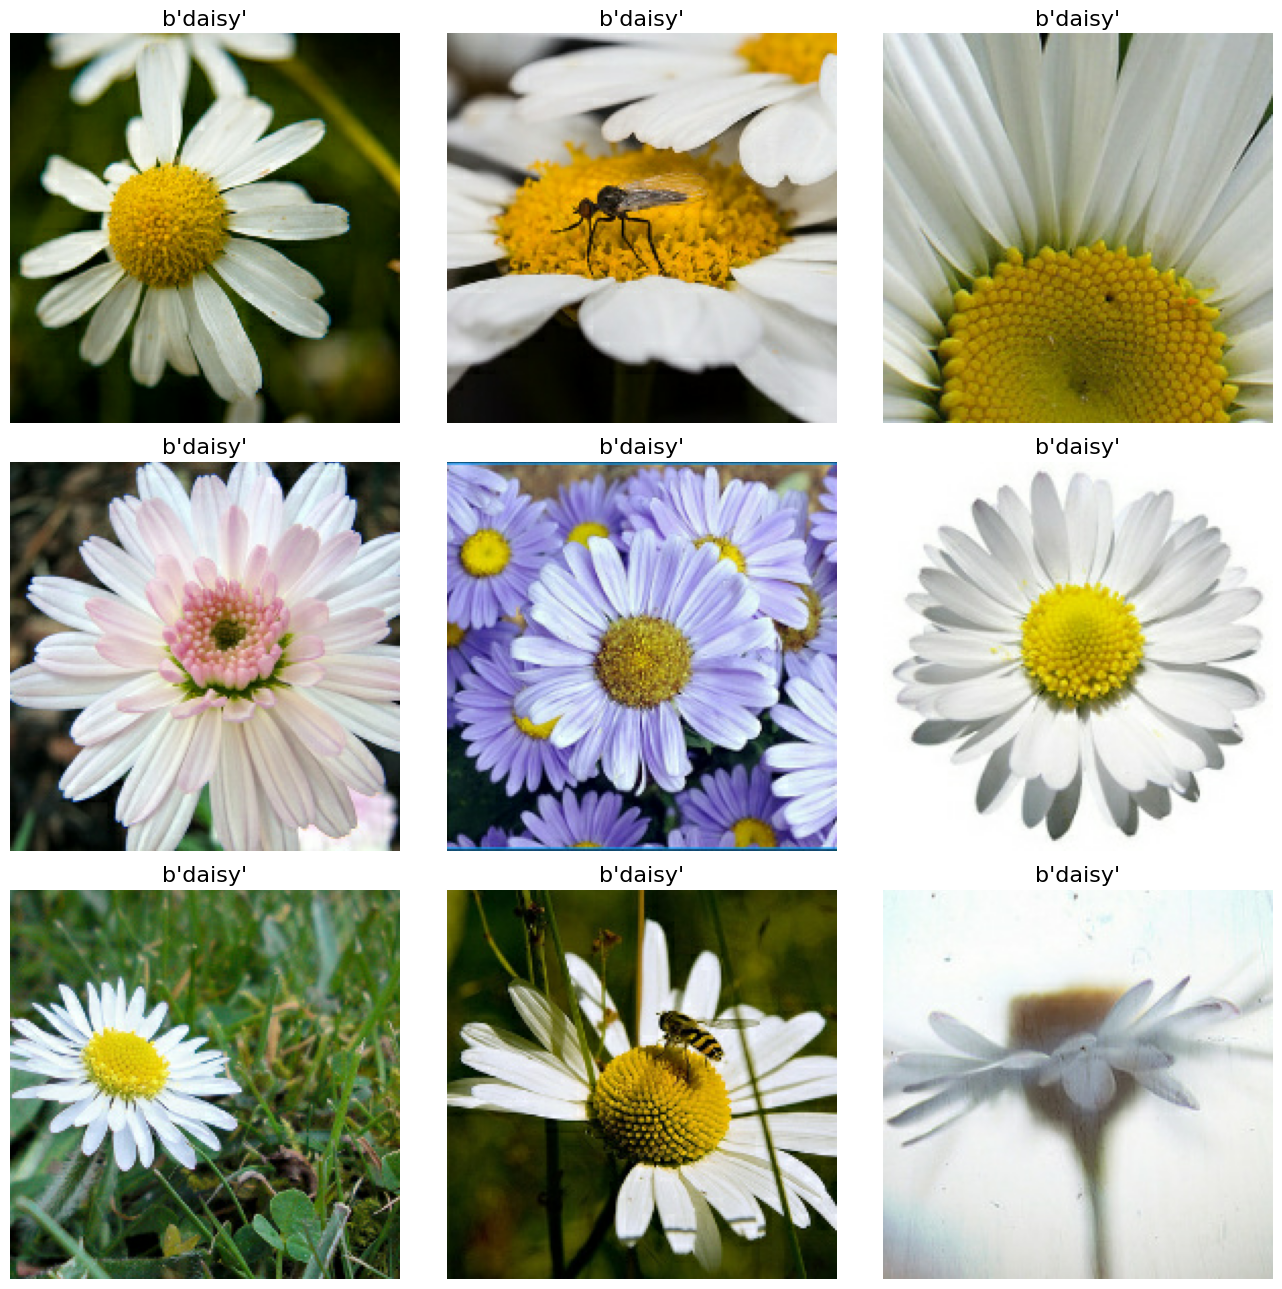

CPU times: user 1.96 s, sys: 176 ms, total: 2.14 s
Wall time: 2.06 s


In [ ]:
%%time
display_9_images_from_dataset(mapped_dataset)

ii) Write your code above into a file using the *cell magic* `%%writefile spark_write_tfrec.py` at the beginning of the file. Then, run the file  locally in Spark.



In [ ]:
%%writefile spark_write_tfrec.py

import sys
import numpy as np
import pyspark
import tensorflow as tf
import argparse
import time

TARGET_SIZE = [192, 192] # target resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
GCS_OUTPUT = 'gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers'
PARTITION_NUM = 2

sc = pyspark.SparkContext.getOrCreate()

def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(tfrec_filewriter, img_bytes, label): # Create tf data records
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,      # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

### i) ###
def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image_label):
    image, label = image_label
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image_label):
    image, label = image_label
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label

### iv) and v)###
def write_tfrecords_to_partition(partition_index, image_label_iter, gcs_output): # write the images to files.
    image_label_list = list(image_label_iter)# this conversion is needed since we use it in len() and the for loop
    partition_size = len(image_label_list) # number of images in the current parition
    partition_filename = gcs_output + "{:02d}-{}.tfrec".format(partition_index, partition_size)

    with tf.io.TFRecordWriter(partition_filename) as out_file:
        for image, label in image_label_list:
          example = to_tfrecord(out_file,
                                image.numpy(),
                                label.numpy())
          out_file.write(example.SerializeToString())

    return [partition_filename]

def runWrite(argv):
  print(argv)

  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--gcs_pattern', metavar='gcs_pattern', required=True,
                      help='The glob  pattern for input files.') # add the required argument gcs_pattern
  parser.add_argument('--gcs_output', metavar='gcs_output', required=True,
                      help='The prefix for output files.') # add the required argument gcs_output
  parser.add_argument('--partition_num', metavar='partition_num', required=True,
                      help='The number of partitions.', type=int)  # add the required argument partition_num

  args = parser.parse_args(argv) # read the value

  gcs_pattern = args.gcs_pattern
  gcs_output = args.gcs_output

  #image_filepaths_rdd = sc.parallelize(tf.io.gfile.glob(gcs_pattern))

  ### TASK 1d ###
  #number of partitions is being passed as an argument
  partition_num = args.partition_num

  start_time = time.time()

  image_filepaths_rdd = sc.parallelize(tf.io.gfile.glob(gcs_pattern), partition_num)

  sampled_image_filepaths_rdd = image_filepaths_rdd.sample(False, 0.02, seed=42)
  sampled_decoded_images_labels_rdd = sampled_image_filepaths_rdd.map(decode_jpeg_and_label)
  sampled_resized_images_labels_rdd = sampled_decoded_images_labels_rdd.map(resize_and_crop_image)

  sampled_recompressed_images_labels_rdd = sampled_resized_images_labels_rdd.map(recompress_image)
  filenames = sampled_recompressed_images_labels_rdd.mapPartitionsWithIndex(lambda index, iter: write_tfrecords_to_partition(index, iter, gcs_output))
  tfrecord_filenames = filenames.collect()

  end_time = time.time()
  processing_time = end_time - start_time

  tfrecord_filenames
  print("Processing time:", processing_time, "seconds")


if  'google.colab' not in sys.modules: # Don't use system arguments running in Colab
    runWrite(sys.argv[1:])
elif __name__ == "__main__" : # but define them manually
    runWrite(["--gcs_pattern", GCS_PATTERN, "--gcs_output", GCS_OUTPUT, "--partition_num", PARTITION_NUM])

Overwriting spark_write_tfrec.py


In [ ]:
!find / -type f -name 'spark_write_tfrec.py' 2>/dev/null

/root/spark_write_tfrec.py


In [ ]:
!ls /root

spark-3.5.0-bin-hadoop3  spark_write_tfrec.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1c) Set up a cluster and run the script. (6%)

Following the example from the labs, set up a cluster to run PySpark jobs in the cloud. You need to set up so that TensorFlow is installed on all nodes in the cluster.  


#### i) Single machine cluster
Set up a cluster with a single machine using the maximal SSD size (100) and 8 vCPUs.

Enable **package installation** by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install).
Then, the **packages are specified** by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow==2.4.0`.

Note: consider using `PIP_PACKAGES="tensorflow numpy"` or `PIP_PACKAGES=tensorflow` in case an older version of tensorflow is causing issues.

When the cluster is running, run your script to check that it works and keep the output cell output. (3%)


In [ ]:
import subprocess

partition_nums = [2, 4, 8, 16, 32, 64] # different partition size options to be passed to rdd.parallelize as the second parameter
REGION = 'southamerica-east1' # change the region since 'us-central1-a' does not have enough resources available to fulfill the request.
filepath = "/root/spark_write_tfrec.py"

In [ ]:
%%time
!gcloud dataproc clusters create $CLUSTER-simple \
    --region=$REGION \
    --image-version 1.5-ubuntu18 \
    --single-node \
    --master-machine-type=n1-standard-8 \
    --master-boot-disk-size=100GB \
    --master-boot-disk-type=pd-ssd \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

Waiting on operation [projects/big-data-project-420514/regions/southamerica-east1/operations/502e2e57-c402-3cb8-9f55-94aa503ec414].

Created [https://dataproc.googleapis.com/v1/projects/big-data-project-420514/regions/southamerica-east1/clusters/big-data-project-420514-cluster-simple] Cluster placed in zone [southamerica-east1-c].
CPU times: user 1.43 s, sys: 181 ms, total: 1.61 s
Wall time: 3min 6s


In [ ]:
!gcloud dataproc clusters describe $CLUSTER-simple --region=$REGION

clusterName: big-data-project-420514-cluster-simple
clusterUuid: 9c6b88b6-a072-4785-aefd-7b666ca22883
config:
  configBucket: dataproc-staging-sa-east1-396009249180-uz2py8dn
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 protobuf==3.19.0
    networkUri: https://www.googleapis.com/compute/v1/projects/big-data-project-420514/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/big-data-project-420514/zones/southameri

Run the script in the cloud and test the output.

In [ ]:
for partition_num in partition_nums:
    command = f"gcloud dataproc jobs submit pyspark --cluster {CLUSTER}-simple --region {REGION} {filepath} -- --gcs_pattern {GCS_PATTERN} --gcs_output {GCS_OUTPUT} --partition_num {partition_num}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    print(f"Output for partition_num={partition_num}:")
    print(stdout.decode("utf-8"))
    print(stderr.decode("utf-8"))
    print(20 * "*")

Output for partition_num=2:
done: true
driverControlFilesUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/9c6b88b6-a072-4785-aefd-7b666ca22883/jobs/8553b8dc2df7485eb830ae23ba54f8ba/
driverOutputResourceUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/9c6b88b6-a072-4785-aefd-7b666ca22883/jobs/8553b8dc2df7485eb830ae23ba54f8ba/driveroutput
jobUuid: 803e2c40-0ca5-36d8-872f-39611727c075
placement:
  clusterName: big-data-project-420514-cluster-simple
  clusterUuid: 9c6b88b6-a072-4785-aefd-7b666ca22883
pysparkJob:
  args:
  - --gcs_pattern
  - gs://flowers-public/*/*.jpg
  - --gcs_output
  - gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers
  - --partition_num
  - '2'
  mainPythonFileUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/9c6b88b6-a072-4785-aefd-7b666ca22883/jobs/8553b8dc2df7485eb830ae23ba54f8ba/staging/spark_write_tfrec.py
reference:
  jobId: 

In the free credit tier on Google Cloud, there are normally the following **restrictions** on compute machines:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persistent disk*
- max 8 *vCPU*s
- no GPUs

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details
The **disks are virtual** disks, where **I/O speed is limited in proportion to the size**, so we should allocate them evenly.
This has mainly an effect on the **time the cluster needs to start**, as we are reading the data mainly from the bucket and we are not writing much to disk at all.  


#### ii) Maximal cluster
Use the **largest possible cluster** within these constraints, i.e. **1 master and 7 worker nodes**.
Each of them with 1 (virtual) CPU.
The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput.

Once the cluster is running, test your script. (3%)

In [ ]:
%%time
!gcloud dataproc clusters create $CLUSTER-maximal \
    --region=$REGION \
    --image-version 1.5-ubuntu18 \
    --num-workers=7 \
    --master-machine-type=n1-standard-1 \
    --worker-machine-type=n1-standard-1 \
    --master-boot-disk-size=100GB \
    --worker-boot-disk-size=50GB \
    --master-boot-disk-type=pd-ssd \
    --worker-boot-disk-type=pd-standard \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'IN_USE_ADDRESSES' quota. Requested 8.0, available 4.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
CPU times: user 47.5 ms, sys: 4.59 ms, total: 52 ms
Wall time: 5.23 s


In [ ]:
# keep the CPU quota within the limit
%%time
!gcloud dataproc clusters create $CLUSTER-maximal \
    --region=$REGION \
    --num-workers=3 \
    --image-version 1.5-ubuntu18 \
    --master-machine-type=n1-standard-1 \
    --worker-machine-type=n1-standard-1 \
    --master-boot-disk-size=100GB \
    --worker-boot-disk-size=50GB \
    --master-boot-disk-type=pd-ssd \
    --worker-boot-disk-type=pd-standard \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

Waiting on operation [projects/big-data-project-420514/regions/southamerica-east1/operations/00b4991e-c213-3969-95b3-1dbfbf879866].

Created [https://dataproc.googleapis.com/v1/projects/big-data-project-420514/regions/southamerica-east1/clusters/big-data-project-420514-cluster-maximal] Cluster placed in zone [southamerica-east1-c].
CPU times: user 2.27 s, sys: 288 ms, total: 2.55 s
Wall time: 5min 9s


In [ ]:
for partition_num in partition_nums:
    command = f"gcloud dataproc jobs submit pyspark --cluster {CLUSTER}-maximal --region {REGION} {filepath} -- --gcs_pattern {GCS_PATTERN} --gcs_output {GCS_OUTPUT} --partition_num {partition_num}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    print(f"Output for partition_num={partition_num}:")
    print(stdout.decode("utf-8"))
    print(stderr.decode("utf-8"))
    print(20 * "*")

Output for partition_num=2:
done: true
driverControlFilesUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/7821f28d-d083-4c8b-85a2-9b955fff25f6/jobs/f2c689c0976a4fdeb2d11f950bfc9a42/
driverOutputResourceUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/7821f28d-d083-4c8b-85a2-9b955fff25f6/jobs/f2c689c0976a4fdeb2d11f950bfc9a42/driveroutput
jobUuid: f6feab7f-9900-3ab4-9dba-6dab1d0ebbd7
placement:
  clusterName: big-data-project-420514-cluster-maximal
  clusterUuid: 7821f28d-d083-4c8b-85a2-9b955fff25f6
pysparkJob:
  args:
  - --gcs_pattern
  - gs://flowers-public/*/*.jpg
  - --gcs_output
  - gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers
  - --partition_num
  - '2'
  mainPythonFileUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/7821f28d-d083-4c8b-85a2-9b955fff25f6/jobs/f2c689c0976a4fdeb2d11f950bfc9a42/staging/spark_write_tfrec.py
reference:
  jobId:

### 1d)	Optimisation, experiments, and discussion (17%)

i) Improve parallelisation

If you implemented a straightfoward version, you will
**probably** observe that **all the computation** is done on only **two nodes**.
This can be adressed by using the **second parameter** in the initial call to **parallelize**.
Make the **suitable change** in the code you have written above and mark it up in comments as `### TASK 1d ###`.

Demonstrate the difference in cluster utilisation before and after the change based on different parameter values with **screenshots from Google Cloud** and measure the **difference in the processing time**. (6%)

ii) Experiment with cluster configurations.

In addition to the experiments above (using 8 VMs),test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with eightfold resources.
Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (7%)

iii) Explain the difference between this use of Spark and most standard applications like e.g. in our labs in terms of where the data is stored. What kind of parallelisation approach is used here? (4%)

Write the code below and your answers in the report.


In [ ]:
# 4 machines with double the resources each (2 vCPUs, memory, disk)
%%time
!gcloud dataproc clusters create $CLUSTER-4-double \
    --region=$REGION \
    --num-workers=3 \
    --master-machine-type=n1-standard-2 \
    --worker-machine-type=n1-standard-2 \
    --master-boot-disk-size=200GB \
    --worker-boot-disk-size=100GB \
    --master-boot-disk-type=pd-ssd \
    --worker-boot-disk-type=pd-standard \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

Waiting on operation [projects/big-data-project-420514/regions/southamerica-east1/operations/53dc9218-ef62-35ee-bce2-74a7d224d364].

Created [https://dataproc.googleapis.com/v1/projects/big-data-project-420514/regions/southamerica-east1/clusters/big-data-project-420514-cluster-4-double] Cluster placed in zone [southamerica-east1-c].
CPU times: user 1.87 s, sys: 241 ms, total: 2.11 s
Wall time: 3min 55s


In [ ]:
for partition_num in partition_nums:
    command = f"gcloud dataproc jobs submit pyspark --cluster {CLUSTER}-4-double --region {REGION} {filepath} -- --gcs_pattern {GCS_PATTERN} --gcs_output {GCS_OUTPUT} --partition_num {partition_num}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    print(f"Output for partition_num={partition_num}:")
    print(stdout.decode("utf-8"))
    print(stderr.decode("utf-8"))
    print(20 * "*")

Output for partition_num=2:
done: true
driverControlFilesUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/f6a04dcd-fcfb-4694-8131-851f3f3d4eec/jobs/2162b8646fe143c0939bd71c83dfe8fc/
driverOutputResourceUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/f6a04dcd-fcfb-4694-8131-851f3f3d4eec/jobs/2162b8646fe143c0939bd71c83dfe8fc/driveroutput
jobUuid: 7d852fad-3f00-3289-b822-d41503eb35ba
placement:
  clusterName: big-data-project-420514-cluster-4-double
  clusterUuid: f6a04dcd-fcfb-4694-8131-851f3f3d4eec
pysparkJob:
  args:
  - --gcs_pattern
  - gs://flowers-public/*/*.jpg
  - --gcs_output
  - gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers
  - --partition_num
  - '2'
  mainPythonFileUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/f6a04dcd-fcfb-4694-8131-851f3f3d4eec/jobs/2162b8646fe143c0939bd71c83dfe8fc/staging/spark_write_tfrec.py
reference:
  jobId

In [ ]:
# 1 machine with eightfold resources
%%time
!gcloud dataproc clusters create $CLUSTER-1-eightfold \
    --region=$REGION \
    --single-node \
    --master-machine-type=n1-standard-8 \
    --master-boot-disk-size=800GB \
    --master-boot-disk-type=pd-ssd \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'SSD_TOTAL_GB' quota. Requested 800.0, available 50.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
CPU times: user 27.8 ms, sys: 9.45 ms, total: 37.2 ms
Wall time: 2.72 s


In [ ]:
# 1 machine with eightfold resources with the max hard disk available (250 GB)
%%time
!gcloud dataproc clusters create $CLUSTER-1-eightfold \
    --region=$REGION \
    --single-node \
    --master-machine-type=n1-standard-8 \
    --master-boot-disk-size=250GB \
    --master-boot-disk-type=pd-ssd \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

Waiting on operation [projects/big-data-project-420514/regions/southamerica-east1/operations/53dffc6c-c119-3557-aa29-23d18f4c98c7].

Created [https://dataproc.googleapis.com/v1/projects/big-data-project-420514/regions/southamerica-east1/clusters/big-data-project-420514-cluster-1-eightfold] Cluster placed in zone [southamerica-east1-c].
CPU times: user 1.2 s, sys: 159 ms, total: 1.36 s
Wall time: 2min 37s


In [ ]:
for partition_num in partition_nums:
    command = f"gcloud dataproc jobs submit pyspark --cluster {CLUSTER}-1-eightfold --region {REGION} {filepath} -- --gcs_pattern {GCS_PATTERN} --gcs_output {GCS_OUTPUT} --partition_num {partition_num}"
    process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()

    print(f"Output for partition_num={partition_num}:")
    print(stdout.decode("utf-8"))
    print(stderr.decode("utf-8"))
    print(20 * "*")

Output for partition_num=2:
done: true
driverControlFilesUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/1212b765-2d4c-49c5-8653-4f87b5db3a76/jobs/1a3c28b4cf744b92828207f824b91a94/
driverOutputResourceUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/1212b765-2d4c-49c5-8653-4f87b5db3a76/jobs/1a3c28b4cf744b92828207f824b91a94/driveroutput
jobUuid: 5142958b-a4f1-3016-9e20-615a1e22b6b8
placement:
  clusterName: big-data-project-420514-cluster-1-eightfold
  clusterUuid: 1212b765-2d4c-49c5-8653-4f87b5db3a76
pysparkJob:
  args:
  - --gcs_pattern
  - gs://flowers-public/*/*.jpg
  - --gcs_output
  - gs://big-data-project-420514-storage/tfrecords-jpeg-192x192-2/flowers
  - --partition_num
  - '2'
  mainPythonFileUri: gs://dataproc-staging-sa-east1-396009249180-uz2py8dn/google-cloud-dataproc-metainfo/1212b765-2d4c-49c5-8653-4f87b5db3a76/jobs/1a3c28b4cf744b92828207f824b91a94/staging/spark_write_tfrec.py
reference:
  jo

# Section 2: Speed tests

We have seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly.
This task is about **measuring this effect** and **parallelizing the tests with PySpark**.

## 2.1 Speed test implementation

Here is **code for time measurement** to determine the **throughput in images per second**.
It doesn't render the images but extracts and prints some basic information in order to make sure the image data are read.
We write the information to the null device for longer measurements `null_file=open("/dev/null", mode='w')`.
That way it will not clutter our cell output.

We use batches ( `dset2 = dset1.batch(batch_size)` ) and select a number of batches with (`dset3 = dset2.take(batch_number)`).
Then we  use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset to see if reading speed changes with mutiple readings.

We then **vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**.
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be combined in a **function** `time_configs()` that takes a configuration, i.e. a dataset and arrays of `batch_sizes`, `batch_numbers`, and  `repetitions` (an array of integers starting from 1), as **arguments** and runs the time measurement for each combination of batch_size and batch_number for the requested number of repetitions.

In [ ]:
# Here are some useful values for testing your code, use higher values later for actually testing throughput
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [1, 2, 3]

def time_configs(dataset, batch_sizes, batch_numbers, repetitions):
    dims = [len(batch_sizes),len(batch_numbers),len(repetitions)]
    print(dims)
    results = np.zeros(dims)
    params = np.zeros(dims + [3])
    print( results.shape )
    with open("/dev/null",mode='w') as null_file: # for printing the output without showing it
        tt = time.time() # for overall time taking
        for bsi,bs in enumerate(batch_sizes):
            for dsi, ds in enumerate(batch_numbers):
                batched_dataset = dataset.batch(bs)
                timing_set = batched_dataset.take(ds)
                for ri,rep in enumerate(repetitions):
                    print("bs: {}, ds: {}, rep: {}".format(bs,ds,rep))
                    t0 = time.time()
                    for image, label in timing_set:
                        #print("Image batch shape {}".format(image.numpy().shape),
                        print("Image batch shape {}, {})".format(image.numpy().shape,
                            [str(lbl) for lbl in label.numpy()]), null_file)
                    td = time.time() - t0 # duration for reading images
                    results[bsi,dsi,ri] = ( bs * ds) / td
                    params[bsi,dsi,ri] = [ bs, ds, rep ]
    print("total time: "+str(time.time()-tt))
    return results, params

**Let's try this function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset4) and the TFRecord files (datasetTfrec).

In [ ]:
[res,par] = time_configs(dataset4, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

print("=============")

[res,par] = time_configs(datasetTfrec, batch_sizes, batch_numbers, repetitions)
print(res)
print(par)

[2, 2, 3]
(2, 2, 3)
bs: 2, ds: 3, rep: 1
Image batch shape (2,), ["b'daisy'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'tulips'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 3, rep: 2
Image batch shape (2,), ["b'daisy'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'daisy'", "b'sunflowers'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
bs: 2, ds: 3, rep: 3
Image batch shape (2,), ["b'dandelion'", "b'daisy'"]) <_io.TextIOWrapper name='/dev/null' mode='w' encoding='UTF-8'>
Image batch shape (2,), ["b'roses'", "b'dandelion'"]) <_io.TextIOWrapper name='/dev/null' mode='w' enc

## Task 2: Parallelising the speed test with Spark in the cloud. (36%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark.
Runing multiple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later).


### 2a) Create the script (14%)
Your task is now to **port the speed test above to Spark** for running it in the cloud in Dataproc.
**Adapt the speed testing** as a Spark program that performs the same actions as above, but **with Spark RDDs in a distributed way**.
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically:
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a Spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (2%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%)
*   vi) write the results to a pickle file in your bucket (2%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [ ]:
### i) ###
%%time
batch_sizes = [2,4]
batch_numbers = [3,6]
repetitions = [3] # as it will be run on an rdd we just need the number of repetitions, no need to start from 1

def create_param_combinations(batch_sizes, batch_numbers, repetitions):
  param_combinations = []
  for batch_size in batch_sizes:
    for batch_number in batch_numbers:
      for repetition in repetitions:
        param_combinations.append((batch_size, batch_number, repetition))

  return param_combinations

param_combinations = sc.parallelize(create_param_combinations(batch_sizes, batch_numbers, repetitions))

CPU times: user 9.83 ms, sys: 1.12 ms, total: 11 ms
Wall time: 652 ms


In [ ]:
%%time
param_combinations.collect()

CPU times: user 22 ms, sys: 2.07 ms, total: 24.1 ms
Wall time: 2.07 s


[(2, 3, 3), (2, 6, 3), (4, 3, 3), (4, 6, 3)]

In [ ]:
### ii) ###
%%time
def time_configs(dataset, batch_size, batch_number, repetitions):
    results = []
    params = []
    with open("/dev/null", mode='w') as null_file:
      batched_dataset = dataset.batch(batch_size)
      tt = time.time()
      timing_set = batched_dataset.take(batch_number)
      for rep in range(repetitions):
        print("bs: {}, ds: {}, rep: {}".format(batch_size,batch_number,rep+1))
        t0 = time.time()
        for image, label in timing_set:
            print("Image batch shape {}, {})".format(image.numpy().shape, [str(lbl) for lbl in label.numpy()]), null_file)
        td = time.time() - t0
        dataset_size = batch_size * batch_number # we need this later, so it will also be included in the results
        results.append(dataset_size / td)
        params.append((batch_size, batch_number, rep+1, dataset_size))
    print("total time: "+str(time.time()-tt))
    return results, params

GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'

def get_images_dataset():
  dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
  dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
  dsetResized = dsetDecoded.map(resize_and_crop_image)
  return dsetResized.map(recompress_image)

def get_tfrecords_dataset():
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  return load_dataset(filenames)


img_results_rdd = param_combinations.map(lambda params: time_configs(get_images_dataset(), *params))
tf_results_rdd = param_combinations.map(lambda params: time_configs(get_images_dataset(), *params))

CPU times: user 1.06 ms, sys: 0 ns, total: 1.06 ms
Wall time: 9.04 ms


In [ ]:
%%time
img_results_rdd.collect()

CPU times: user 197 ms, sys: 24.5 ms, total: 222 ms
Wall time: 21.9 s


[([9.161606317569868, 8.42654148089985, 11.390456499521585],
  [(2, 3, 1, 6), (2, 3, 2, 6), (2, 3, 3, 6)]),
 ([16.48812962331443, 11.831257426615345, 10.495730944397177],
  [(2, 6, 1, 12), (2, 6, 2, 12), (2, 6, 3, 12)]),
 ([11.663147445117454, 13.418849280036856, 16.683996947720768],
  [(4, 3, 1, 12), (4, 3, 2, 12), (4, 3, 3, 12)]),
 ([12.742810377467762, 8.734724364518847, 17.890678135093836],
  [(4, 6, 1, 24), (4, 6, 2, 24), (4, 6, 3, 24)])]

In [ ]:
%%time
tf_results_rdd.collect()

CPU times: user 89.5 ms, sys: 4.71 ms, total: 94.2 ms
Wall time: 7.93 s


[([10.579498767201896, 12.247364822281542, 11.253718435057685],
  [(2, 3, 1, 6), (2, 3, 2, 6), (2, 3, 3, 6)]),
 ([16.61175735944745, 19.47679752030137, 17.00662402028429],
  [(2, 6, 1, 12), (2, 6, 2, 12), (2, 6, 3, 12)]),
 ([12.961020614120587, 17.180376440341192, 15.897782469359946],
  [(4, 3, 1, 12), (4, 3, 2, 12), (4, 3, 3, 12)]),
 ([20.340436761518916, 21.30958773034707, 24.62896188874905],
  [(4, 6, 1, 24), (4, 6, 2, 24), (4, 6, 3, 24)])]

In [ ]:
### iii) ###
%%time
img_transformed_rdd = img_results_rdd.flatMap(lambda x: [(params, throughput) for throughput, params in zip(x[0], x[1])])
img_transformed_rdd.collect()

CPU times: user 111 ms, sys: 8.4 ms, total: 119 ms
Wall time: 10.2 s


[((2, 3, 1, 6), 11.63671338000197),
 ((2, 3, 2, 6), 17.327455112929446),
 ((2, 3, 3, 6), 6.184379650727307),
 ((2, 6, 1, 12), 11.199658925588903),
 ((2, 6, 2, 12), 9.964510241450807),
 ((2, 6, 3, 12), 10.612193227942996),
 ((4, 3, 1, 12), 14.752248596413326),
 ((4, 3, 2, 12), 11.224843447218758),
 ((4, 3, 3, 12), 12.79859715897229),
 ((4, 6, 1, 24), 10.896588632933163),
 ((4, 6, 2, 24), 15.628570749881346),
 ((4, 6, 3, 24), 19.689072277223076)]

In [ ]:
tf_transformed_rdd = tf_results_rdd.flatMap(lambda x: [(params, throughput) for throughput, params in zip(x[0], x[1])])
tf_transformed_rdd.collect()

[((2, 3, 1, 6), 8.385849055660687),
 ((2, 3, 2, 6), 10.382565946628798),
 ((2, 3, 3, 6), 12.80663103759576),
 ((2, 6, 1, 12), 14.147326951082434),
 ((2, 6, 2, 12), 17.074007786008252),
 ((2, 6, 3, 12), 14.059606533857597),
 ((4, 3, 1, 12), 12.117289985687476),
 ((4, 3, 2, 12), 14.309768336047068),
 ((4, 3, 3, 12), 17.88617685093481),
 ((4, 6, 1, 24), 19.346814799040725),
 ((4, 6, 2, 24), 20.666211173595418),
 ((4, 6, 3, 24), 23.092466862729804)]

In [ ]:
### iv) ###
%%time
img_batch_size_results_rdd = img_transformed_rdd.map(lambda x: (x[0][0], x[1])) # (batch_size, images_per_second)
img_batch_number_results_rdd = img_transformed_rdd.map(lambda x: (x[0][1], x[1])) # (batch_number, images_per_second)
img_repetition_results_rdd = img_transformed_rdd.map(lambda x: (x[0][2], x[1])) # (repetition, images_per_second)
img_dataset_size_results_rdd = img_transformed_rdd.map(lambda x: (x[0][3], x[1])) # (dataset_size, images_per_second)

CPU times: user 615 µs, sys: 0 ns, total: 615 µs
Wall time: 626 µs


In [ ]:
tf_batch_size_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][0], x[1])) # (batch_size, images_per_second)
tf_batch_number_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][1], x[1])) # (batch_number, images_per_second)
tf_repetition_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][2], x[1])) # (repetition, images_per_second)
tf_dataset_size_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][3], x[1])) # (dataset_size, images_per_second)

In [ ]:
%%time
img_batch_size_results_rdd.collect()

CPU times: user 126 ms, sys: 8.37 ms, total: 134 ms
Wall time: 11.4 s


[(2, 7.565394705870151),
 (2, 9.09768127887556),
 (2, 8.689457286664666),
 (2, 11.207856510286597),
 (2, 9.634254481848936),
 (2, 9.875857879422727),
 (4, 9.383352877461116),
 (4, 12.863907990160058),
 (4, 13.692631304035562),
 (4, 10.733432844828496),
 (4, 16.46539166835279),
 (4, 19.382207269610845)]

In [ ]:
%%time
img_batch_number_results_rdd.collect()

CPU times: user 114 ms, sys: 14 ms, total: 128 ms
Wall time: 11.1 s


[(3, 9.041396852769994),
 (3, 8.774517112275973),
 (3, 7.546881649037861),
 (6, 14.819614131436516),
 (6, 11.509817211884384),
 (6, 10.035058351166096),
 (3, 11.378096716759096),
 (3, 11.289545030306714),
 (3, 14.168968638142921),
 (6, 14.201928272593603),
 (6, 12.369587637797007),
 (6, 11.805229242750887)]

In [ ]:
%%time
img_repetition_results_rdd.collect()

CPU times: user 113 ms, sys: 10.1 ms, total: 123 ms
Wall time: 10.1 s


[(1, 6.490439906658331),
 (2, 7.79637459540108),
 (3, 6.4288863024882925),
 (1, 14.935645883959202),
 (2, 13.299474380126854),
 (3, 9.333590479270576),
 (1, 10.42193217911056),
 (2, 12.094249880695441),
 (3, 16.10336015859035),
 (1, 14.93070797212294),
 (2, 16.708261006824834),
 (3, 23.733725094374186)]

In [ ]:
%%time
img_dataset_size_results_rdd.collect()

CPU times: user 101 ms, sys: 12 ms, total: 113 ms
Wall time: 8.4 s


[(6, 9.898346737192455),
 (6, 11.673515925605516),
 (6, 14.080917442588499),
 (12, 15.350878857075584),
 (12, 15.918180763003981),
 (12, 13.551487639687085),
 (12, 18.647870959328003),
 (12, 15.767773643210743),
 (12, 17.464611464154824),
 (24, 18.86136191212647),
 (24, 16.247994448810566),
 (24, 17.335040260544048)]

In [ ]:
%%time
tf_batch_size_results_rdd.collect()

CPU times: user 115 ms, sys: 9.46 ms, total: 124 ms
Wall time: 10.3 s


[(2, 8.331978320680442),
 (2, 7.395576787612396),
 (2, 6.757199343339336),
 (2, 11.021004255855853),
 (2, 10.49299579501698),
 (2, 10.966382264718014),
 (4, 9.759195991124134),
 (4, 10.743496480568847),
 (4, 14.473098688750863),
 (4, 13.121794579335505),
 (4, 19.941902933301215),
 (4, 29.44433634826133)]

In [ ]:
%%time
tf_batch_number_results_rdd.collect()

CPU times: user 87.2 ms, sys: 5.13 ms, total: 92.3 ms
Wall time: 7.66 s


[(3, 10.165175769179502),
 (3, 11.800198906436608),
 (3, 12.730116704512632),
 (6, 17.34465207415673),
 (6, 15.466487863982946),
 (6, 15.217245445255386),
 (3, 14.087873769170763),
 (3, 15.518208246734208),
 (3, 17.375392858129196),
 (6, 17.452493703888766),
 (6, 21.613736146705783),
 (6, 26.6968906805283)]

In [ ]:
%%time
tf_repetition_results_rdd.collect()

CPU times: user 107 ms, sys: 15.3 ms, total: 122 ms
Wall time: 10.8 s


[(1, 8.331109459546695),
 (2, 9.316458995225124),
 (3, 8.109866482421518),
 (1, 11.411216815769409),
 (2, 9.920996916174953),
 (3, 7.868743709354103),
 (1, 10.916997314545636),
 (2, 12.060155514123673),
 (3, 15.937627116067913),
 (1, 10.167586561044127),
 (2, 13.71482757840807),
 (3, 21.429704949916676)]

In [ ]:
%%time
tf_dataset_size_results_rdd.collect()

CPU times: user 119 ms, sys: 6.63 ms, total: 125 ms
Wall time: 9.92 s


[(6, 6.741546955553859),
 (6, 7.989837855891729),
 (6, 8.799980697674174),
 (12, 12.449524680195218),
 (12, 12.22774195037395),
 (12, 18.14077326974479),
 (12, 10.649342779546146),
 (12, 11.411330651807559),
 (12, 11.28607434169338),
 (24, 18.73603400592364),
 (24, 19.657106613952614),
 (24, 27.007064372420214)]

In [ ]:
### v) ###
def sum_count(value):
  return value, 1

def combine_sum_count(x, value):
  return x[0] + value, x[1] + 1

def merge_values(x, y):
    sum_x, count_x = x
    sum_y, count_y = y
    return sum_x + sum_y, count_x + count_y

def calculate_average(results_rdd):
    sum_count_rdd = results_rdd.combineByKey(
        sum_count,
        combine_sum_count,
        merge_values)
    return sum_count_rdd.mapValues(lambda x: x[0] / x[1])

In [ ]:
# just to test the calculate_average function
%%time
test_list = [
    (2, 7.703763929994012),
    (2, 8.680166099102763),
    (2, 9.89405821596687),
    (2, 11.841358749661216),
    (2, 14.509271735088342),
    (2, 10.713933298210323),
    (4, 12.706841828351916),
    (4, 13.24520886770988),
    (4, 11.689199630732787),
    (4, 14.497985312665044),
    (4, 13.986100777491146),
    (4, 9.133188116828396)
]

test_rdd = sc.parallelize(test_list)
calculate_average(test_rdd).collect()

CPU times: user 52.3 ms, sys: 3.72 ms, total: 56 ms
Wall time: 3.52 s


[(4, 12.543087422296528), (2, 10.557092004670588)]

In [ ]:
img_average_batch_size_speed = calculate_average(img_batch_size_results_rdd)
img_average_batch_number_speed = calculate_average(img_batch_number_results_rdd)
img_average_repetition_speed = calculate_average(img_repetition_results_rdd)
img_average_dataset_size_speed = calculate_average(img_dataset_size_results_rdd)

In [ ]:
tf_average_batch_size_speed = calculate_average(tf_batch_size_results_rdd)
tf_average_batch_number_speed = calculate_average(tf_batch_number_results_rdd)
tf_average_repetition_speed = calculate_average(tf_repetition_results_rdd)
tf_average_dataset_size_speed = calculate_average(tf_dataset_size_results_rdd)

In [ ]:
%%time
img_average_batch_size_speed.collect()

CPU times: user 92.1 ms, sys: 14.8 ms, total: 107 ms
Wall time: 12.3 s


[(2, 9.955466826810023), (4, 14.327603851037443)]

In [ ]:
%%time
img_average_batch_number_speed.collect()

CPU times: user 68.6 ms, sys: 13.3 ms, total: 81.9 ms
Wall time: 9 s


[(6, 20.08416004406003), (3, 15.109693565308495)]

In [ ]:
%%time
img_average_repetition_speed.collect()

CPU times: user 182 ms, sys: 26.2 ms, total: 208 ms
Wall time: 24 s


[(2, 6.611968972697431), (3, 7.660299835280512), (1, 7.773296276550326)]

In [ ]:
%%time
img_average_dataset_size_speed.collect()

CPU times: user 155 ms, sys: 15.1 ms, total: 170 ms
Wall time: 19.5 s


[(6, 5.77822821500385), (24, 10.735980627228495), (12, 7.449280922737397)]

In [ ]:
%%time
tf_average_batch_size_speed.collect()

CPU times: user 130 ms, sys: 16 ms, total: 145 ms
Wall time: 15.2 s


[(4, 10.861196318043044), (2, 7.593913579771185)]

In [ ]:
%%time
tf_average_batch_number_speed.collect()

CPU times: user 77.1 ms, sys: 3.85 ms, total: 81 ms
Wall time: 8.85 s


[(6, 19.848917293559627), (3, 14.706079869457616)]

In [ ]:
%%time
tf_average_repetition_speed.collect()

CPU times: user 96.5 ms, sys: 8.73 ms, total: 105 ms
Wall time: 11.8 s


[(2, 11.22977072872136), (3, 10.555329558911083), (1, 12.98781836040459)]

In [ ]:
%%time
tf_average_dataset_size_speed.collect()

CPU times: user 73.7 ms, sys: 9.27 ms, total: 83 ms
Wall time: 9.41 s


[(6, 12.285462619906616), (24, 21.706569325418002), (12, 16.349447476373665)]

In [ ]:
### vi) ###
%%time

def write_to_pickle(rdds_dict, filename, bucketname):
  with open(filename,mode='wb') as f:
      pickle.dump(rdds_dict,f)

  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucketname],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))
  if proc.returncode == 0:
    print("File Content:", rdds_dict)
    print(f"{filename} has been written to the bucket.")

rdds_dict = {
    "img": {
        "img_average_batch_size_speed": img_average_batch_size_speed.collect(),
        "img_average_batch_number_speed": img_average_batch_number_speed.collect(),
        "img_average_repetition_speed": img_average_repetition_speed.collect(),
        "img_average_dataset_size_speed": img_average_dataset_size_speed.collect(),

        "raw_img_batch_size_results_rdd": img_batch_size_results_rdd.collect(),
        "raw_img_batch_number_results_rdd": img_batch_number_results_rdd.collect(),
        "raw_img_repetition_results_rdd": img_repetition_results_rdd.collect(),
        "raw_img_dataset_size_results_rdd": img_dataset_size_results_rdd.collect()
    },
    "tf": {
        "tf_average_batch_size_speed": tf_average_batch_size_speed.collect(),
        "tf_average_batch_number_speed": tf_average_batch_number_speed.collect(),
        "tf_average_repetition_speed": tf_average_repetition_speed.collect(),
        "tf_average_dataset_size_speed": tf_average_dataset_size_speed.collect(),

        "raw_tf_batch_size_results_rdd": tf_batch_size_results_rdd.collect(),
        "raw_tf_batch_number_results_rdd": tf_batch_number_results_rdd.collect(),
        "raw_tf_repetition_results_rdd": tf_repetition_results_rdd.collect(),
        "raw_tf_dataset_size_results_rdd": tf_dataset_size_results_rdd.collect()
    }
}

filename = f"rdd_results{datetime.datetime.now().strftime('%y%m%d-%H%M')}.pickle"

write_to_pickle(rdds_dict, filename, BUCKET)

gstuil returned: 0
b'Copying file://rdd_results240505-0227.pickle [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  2.1 KiB]                                                \r/ [1 files][  2.1 KiB/  2.1 KiB]                                                \r-\r\nOperation completed over 1 objects/2.1 KiB.                                      \n'
File Content: {'img': {'img_average_batch_size_speed': [(2, 9.955466826810023), (4, 14.327603851037443)], 'img_average_batch_number_speed': [(6, 20.08416004406003), (3, 15.109693565308495)], 'img_average_repetition_speed': [(2, 6.611968972697431), (3, 7.660299835280512), (1, 7.773296276550326)], 'img_average_dataset_size_speed': [(12, 7.449280922737397), (6, 5.77822821500385), (24, 10.735980627228495)], 'raw_img_batch_size_results_rdd': [(2, 7.731155675462456), (2, 10.848951244904953), (2, 8.855801723807268), (2, 11.426265429380138), (2, 7.809836627229291), (2, 8.185494503635864), (4, 11.811946267143542), (4, 16.210361279858393)

In [ ]:
#just to test reading back the values from the pickle file on bucket
%%time

import subprocess

def read_from_pickle(filename, bucketname):
    local_filepath = f"/content/{filename}"
    proc = subprocess.run(["gsutil", "cp", f"{bucketname}/{filename}", local_filepath], stderr=subprocess.PIPE)
    if proc.returncode == 0:
        print(f"{filename} has been downloaded from the bucket.")
        with open(local_filepath, 'rb') as f:
          data = pickle.load(f)
          print("File Content:", data)
    else:
        print("Error downloading file from the bucket:")
        print(proc.stderr)
        return None

read_from_pickle(filename, BUCKET)

rdd_results240505-0227.pickle has been downloaded from the bucket.
File Content: {'img': {'img_average_batch_size_speed': [(2, 9.955466826810023), (4, 14.327603851037443)], 'img_average_batch_number_speed': [(6, 20.08416004406003), (3, 15.109693565308495)], 'img_average_repetition_speed': [(2, 6.611968972697431), (3, 7.660299835280512), (1, 7.773296276550326)], 'img_average_dataset_size_speed': [(12, 7.449280922737397), (6, 5.77822821500385), (24, 10.735980627228495)], 'raw_img_batch_size_results_rdd': [(2, 7.731155675462456), (2, 10.848951244904953), (2, 8.855801723807268), (2, 11.426265429380138), (2, 7.809836627229291), (2, 8.185494503635864), (4, 11.811946267143542), (4, 16.210361279858393), (4, 11.60827271651672), (4, 10.555188954344903), (4, 13.329059417110425), (4, 17.969132518816455)], 'raw_img_batch_number_results_rdd': [(3, 10.444985388290462), (3, 11.686992962956255), (3, 11.588534610662853), (6, 17.266715884172363), (6, 18.77257138509291), (6, 17.640878110535603), (3, 14.64

In [ ]:
### vii) ###
%%writefile spark_job.py

import sys
import numpy as np
import pyspark
import tensorflow as tf
import argparse
import time
import datetime
import pickle

sc = pyspark.SparkContext.getOrCreate()

GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/'
GCS_PATTERN = 'gs://flowers-public/*/*.jpg' # glob  pattern for input files
GCS_BUCKET = 'gs://big-data-project-420514-storage'



### MAP FUNCTIONS START ###
TARGET_SIZE = [192, 192] # target resolution for the images

def decode_jpeg_and_label(filepath):
    # extracts the image data and creates a class label, based on the filepath
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resizes and cropd using "fill" algorithm:
    # always make sure the resulting image is cut out from the source image
    # so that it fills the TARGET_SIZE entirely with no black bars
    # and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label

def recompress_image(image, label):
    # this reduces the amount of data, but takes some time
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return image, label
### MAP FUNCTIONS END ###

### TF Record FUNCTIONS START ###
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    class_num = example['class']
    return image, class_num

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset
### TF Record FUNCTIONS END ###



### i) ###
batch_sizes = [2, 4, 6, 8]
batch_numbers = [3, 6, 9, 12]
repetitions = [4] #as it will be run on an rdd we just need the number of repetitions, no need to start from 1

def create_param_combinations(batch_sizes, batch_numbers, repetitions):
  param_combinations = []
  for batch_size in batch_sizes:
    for batch_number in batch_numbers:
      for repetition in repetitions:
        param_combinations.append((batch_size, batch_number, repetition))

  return param_combinations


### ii) ###
def time_configs(dataset, batch_size, batch_number, repetitions):
    results = []
    params = []
    with open("/dev/null", mode='w') as null_file:
      batched_dataset = dataset.batch(batch_size)
      tt = time.time()
      timing_set = batched_dataset.take(batch_number)
      for rep in range(repetitions):
        print("bs: {}, ds: {}, rep: {}".format(batch_size,batch_number,rep+1))
        t0 = time.time()
        for image, label in timing_set:
            print("Image batch shape {}, {})".format(image.numpy().shape, [str(lbl) for lbl in label.numpy()]), null_file)
        td = time.time() - t0
        dataset_size = batch_size * batch_number # we need this later, so it will also be included in the results
        results.append(dataset_size / td)
        params.append((batch_size, batch_number, rep+1, dataset_size))
    print("total time: "+str(time.time()-tt))
    return results, params

def get_tfrecords_dataset():
  filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
  return load_dataset(filenames)

def get_images_dataset():
  dsetFiles = tf.data.Dataset.list_files(GCS_PATTERN)
  dsetDecoded = dsetFiles.map(decode_jpeg_and_label)
  dsetResized = dsetDecoded.map(resize_and_crop_image)
  return dsetResized.map(recompress_image)


### v) ###
def sum_count(value):
  return value, 1

def combine_sum_count(x, value):
  return x[0] + value, x[1] + 1

def merge_values(x, y):
    sum_x, count_x = x
    sum_y, count_y = y
    return sum_x + sum_y, count_x + count_y

def calculate_average(results_rdd):
    sum_count_rdd = results_rdd.combineByKey(
        sum_count,
        combine_sum_count,
        merge_values)
    return sum_count_rdd.mapValues(lambda x: x[0] / x[1])


### vi) ###
def write_to_pickle(rdds_dict, filename, bucketname):
  with open(filename,mode='wb') as f:
      pickle.dump(rdds_dict,f)

  import subprocess
  proc = subprocess.run(["gsutil","cp", filename, bucketname],stderr=subprocess.PIPE)
  print("gstuil returned: " + str(proc.returncode))
  print(str(proc.stderr))
  if proc.returncode == 0:
    print("File Content:", rdds_dict)
    print(f"{filename} has been written to the bucket.")


def runAll(argv):
  print(argv)

  parser = argparse.ArgumentParser() # get a parser object
  parser.add_argument('--gcs_bucket', metavar='gcs_bucket', required=True,
                      help='The bucket for output files.') # add the required argument gcs_bucket

  args = parser.parse_args(argv) # read the value

  gcs_bucket = args.gcs_bucket

  start_time = time.time()


  ### i) ###
  param_combinations = sc.parallelize(create_param_combinations(batch_sizes, batch_numbers, repetitions))

  ### ii) ###
  img_results_rdd = param_combinations.map(lambda params: time_configs(get_images_dataset(), *params)).cache() ### TASK 2c ###
  tf_results_rdd = param_combinations.map(lambda params: time_configs(get_images_dataset(), *params)).cache() ### TASK 2c ###

  ### iii) ###
  img_transformed_rdd = img_results_rdd.flatMap(lambda x: [(params, throughput) for throughput, params in zip(x[0], x[1])])#.cache() ### TASK 2c ###
  tf_transformed_rdd = tf_results_rdd.flatMap(lambda x: [(params, throughput) for throughput, params in zip(x[0], x[1])])#.cache() ### TASK 2c ###

  ### iv) ###
  img_batch_size_results_rdd = img_transformed_rdd.map(lambda x: (x[0][0], x[1]))#.cache() ### TASK 2c ###  # (batch_size, images_per_second)
  img_batch_number_results_rdd = img_transformed_rdd.map(lambda x: (x[0][1], x[1]))#.cache() ### TASK 2c ###  # (batch_number, images_per_second)
  img_repetition_results_rdd = img_transformed_rdd.map(lambda x: (x[0][2], x[1]))#.cache() ### TASK 2c ###    # (repetition, images_per_second)
  img_dataset_size_results_rdd = img_transformed_rdd.map(lambda x: (x[0][3], x[1]))#.cache() ### TASK 2c ###    # (dataset_size, images_per_second)

  tf_batch_size_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][0], x[1]))#.cache() ### TASK 2c ###  # (batch_size, images_per_second)
  tf_batch_number_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][1], x[1]))#.cache() ### TASK 2c ###  # (batch_number, images_per_second)
  tf_repetition_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][2], x[1]))#.cache() ### TASK 2c ###    # (repetition, images_per_second)
  tf_dataset_size_results_rdd = tf_transformed_rdd.map(lambda x: (x[0][3], x[1]))#.cache() ### TASK 2c ###    # (dataset_size, images_per_second)

  ### v) ###
  img_average_batch_size_speed = calculate_average(img_batch_size_results_rdd)#.cache() ### TASK 2c ###
  img_average_batch_number_speed = calculate_average(img_batch_number_results_rdd)#.cache() ### TASK 2c ###
  img_average_repetition_speed = calculate_average(img_repetition_results_rdd)#.cache() ### TASK 2c ###
  img_average_dataset_size_speed = calculate_average(img_dataset_size_results_rdd)#.cache() ### TASK 2c ###

  tf_average_batch_size_speed = calculate_average(tf_batch_size_results_rdd)#.cache() ### TASK 2c ###
  tf_average_batch_number_speed = calculate_average(tf_batch_number_results_rdd)#.cache() ### TASK 2c ###
  tf_average_repetition_speed = calculate_average(tf_repetition_results_rdd)#.cache() ### TASK 2c ###
  tf_average_dataset_size_speed = calculate_average(tf_dataset_size_results_rdd)#.cache() ### TASK 2c ###

  ### vi) ###

  rdds_dict = {
      "img": {
          "img_average_batch_size_speed": img_average_batch_size_speed.collect(),
          "img_average_batch_number_speed": img_average_batch_number_speed.collect(),
          "img_average_repetition_speed": img_average_repetition_speed.collect(),
          "img_average_dataset_size_speed": img_average_dataset_size_speed.collect(),

          "raw_img_batch_size_results_rdd": img_batch_size_results_rdd.collect(),
          "raw_img_batch_number_results_rdd": img_batch_number_results_rdd.collect(),
          "raw_img_repetition_results_rdd": img_repetition_results_rdd.collect(),
          "raw_img_dataset_size_results_rdd": img_dataset_size_results_rdd.collect()
      },
      "tf": {
          "tf_average_batch_size_speed": tf_average_batch_size_speed.collect(),
          "tf_average_batch_number_speed": tf_average_batch_number_speed.collect(),
          "tf_average_repetition_speed": tf_average_repetition_speed.collect(),
          "tf_average_dataset_size_speed": tf_average_dataset_size_speed.collect(),

          "raw_tf_batch_size_results_rdd": tf_batch_size_results_rdd.collect(),
          "raw_tf_batch_number_results_rdd": tf_batch_number_results_rdd.collect(),
          "raw_tf_repetition_results_rdd": tf_repetition_results_rdd.collect(),
          "raw_tf_dataset_size_results_rdd": tf_dataset_size_results_rdd.collect()
      }
  }

  filename = f"rdd_results{datetime.datetime.now().strftime('%y%m%d-%H%M')}.pickle"

  write_to_pickle(rdds_dict, filename, gcs_bucket)

  end_time = time.time()
  processing_time = end_time - start_time
  print("Processing time:", processing_time, "seconds")



if  'google.colab' not in sys.modules: # Don't use system arguments running in Colab
    runAll(sys.argv[1:])
elif __name__ == "__main__" : # but define them manually
    runAll(["--gcs_bucket", GCS_BUCKET])

Overwriting spark_job.py


### 2b) Testing the code and collecting results (4%)

i) First, test locally with `%run`.

It is useful to create a **new filename argument**, so that old results don't get overwritten.

You can for instance use `datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

In [ ]:
%%time
%run spark_job.py

['--gcs_bucket', 'gs://big-data-project-420514-storage']
gstuil returned: 0
b'Copying file://rdd_results240505-0235.pickle [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/  2.1 KiB]                                                \r/ [1 files][  2.1 KiB/  2.1 KiB]                                                \r\nOperation completed over 1 objects/2.1 KiB.                                      \n'
File Content: {'img': {'img_average_batch_size_speed': [(2, 12.39744444955185), (4, 11.919714404142452)], 'img_average_batch_number_speed': [(6, 14.085070367724796), (3, 10.232088485969506)], 'img_average_repetition_speed': [(2, 12.078423304133862), (3, 13.537345895815019), (1, 10.859969080592574)], 'img_average_dataset_size_speed': [(6, 10.210693306404254), (24, 13.585945142750148), (12, 12.418839629117102)], 'raw_img_batch_size_results_rdd': [(2, 6.484678339306738), (2, 9.98314207372804), (2, 14.16425950617798), (2, 13.28701763871055), (2, 15.001324234079759), (2, 15.464244

ii) Cloud

If  you have a cluster running, you can run the  speed test job in the cloud.

While you run this job, switch to the Dataproc web page and take **screenshots of the CPU and network load** over time. They are displayed with some delay, so you may need to wait a little. These images will be useful in the next task. Again, don't use the SCREENSHOT function that Google provides, but just take a picture of the graphs you see for the VMs.


In [ ]:
REGION = 'southamerica-east1'

In [ ]:
# keep the CPU quota within the limit
%%time
!gcloud dataproc clusters create $CLUSTER-maximal \
    --region=$REGION \
    --num-workers=3 \
    --image-version 1.5-ubuntu18 \
    --master-machine-type=n1-standard-1 \
    --worker-machine-type=n1-standard-1 \
    --master-boot-disk-size=100GB \
    --worker-boot-disk-size=50GB \
    --master-boot-disk-type=pd-ssd \
    --worker-boot-disk-type=pd-standard \
    --num-worker-local-ssds=0 \
    --initialization-actions gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    --metadata PIP_PACKAGES="tensorflow==2.4.0 protobuf==3.19.0"

ERROR: (gcloud.dataproc.clusters.create) INVALID_ARGUMENT: Insufficient 'IN_USE_ADDRESSES' quota. Requested 4.0, available 0.0. Your resource request exceeds your available quota. See https://cloud.google.com/compute/resource-usage. Use https://cloud.google.com/docs/quotas/view-manage#requesting_higher_quota to request additional quota.
CPU times: user 65.5 ms, sys: 4.46 ms, total: 70 ms
Wall time: 5.33 s


In [ ]:
!gcloud dataproc clusters describe $CLUSTER-maximal --region=$REGION

clusterName: big-data-project-420514-cluster-maximal
clusterUuid: 96e85eae-6325-4615-b4d4-45593c15941b
config:
  configBucket: dataproc-staging-sa-east1-396009249180-uz2py8dn
  endpointConfig: {}
  gceClusterConfig:
    internalIpOnly: false
    metadata:
      PIP_PACKAGES: tensorflow==2.4.0 protobuf==3.19.0
    networkUri: https://www.googleapis.com/compute/v1/projects/big-data-project-420514/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    - https://www.googleapis.com/auth/monitoring.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/big-data-project-420514/zones/southamer

In [ ]:
!find / -type f -name 'spark_job.py' 2>/dev/null

/root/spark_job.py
/content/spark_job.py


In [ ]:
%%time
filepath = "/root/spark_job.py"
GCS_BUCKET = 'gs://big-data-project-420514-storage'

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER-maximal --region $REGION \
    $filepath \
    -- --gcs_bucket $GCS_BUCKET

Job [acd591cd6a0a4c26b57a985d5691b6f5] submitted.
Waiting for job output...
2024-05-05 05:06:20.071030: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2024-05-05 05:06:20.071537: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
24/05/05 05:06:26 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/05/05 05:06:26 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/05/05 05:06:26 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator
24/05/05 05:06:26 INFO org.spark_project.jetty.util.log: Logging initialized @12217ms to org.spark_project.jetty.util.log.Slf4jLog
24/05/05 05:06:26 INFO org.spark_project.jetty.server.Server: jetty-9.4.z-SNAPSHOT; built: unknown; git: unknown;

### 2c) Improve efficiency (6%)

If you implemented a straightfoward version of 2a), you will **probably have an inefficiency** in your code.

Because we are reading multiple times from an RDD to read the values for the different parameters and their averages, caching existing results is important. Explain **where in the process caching can help**, and **add a call to `RDD.cache()`** to your code, if you haven't yet. Measure the the effect of using caching or not using it.

Make the **suitable change** in the code you have written above and mark them up in comments as `### TASK 2c ###`.

Explain in your report what the **reasons for this change** are and **demonstrate and interpret its effect**

### 2d) Retrieve, analyse and discuss the output (12%)

Run the tests over a wide range of different paramters and list the results in a table.

Perform a **linear regression** (e.g. using scikit-learn) over **the values for each parameter** and for the **two cases** (reading from image files/reading TFRecord files).
List a **table** with the output and interpret the results in terms of the effects of overall.  
Also, **plot** the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the **implications** of this result for **applications** like large-scale machine learning.
Keep in mind that cloud data may be stored in distant physical locations.
Use the numbers provided in the PDF latency-numbers document available on Moodle or [here](https://gist.github.com/hellerbarde/2843375) for your arguments.

How is the **observed** behaviour **similar or different** from what you’d expect from a **single machine**? Why would cloud providers tie throughput to capacity of disk resources?

By **parallelising** the speed test we are making **assumptions** about the limits of the bucket reading speeds.
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, **what we need to consider** in **speed tests** in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results.

Discuss to what extent **linear modelling** reflects the **effects** we are observing.
Discuss what could be expected from a theoretical perspective and what can be useful in practice.
  
Write your **code below** and **include the output** in your submitted `ipynb` file. Provide the answer **text in your report**.

In [10]:
filename = "rdd_results240505-0524.pickle"

In [13]:
%%time
import subprocess

def read_from_pickle(filename, bucketname):
    local_filepath = f"/content/{filename}"
    proc = subprocess.run(["gsutil", "cp", f"{bucketname}/{filename}", local_filepath], stderr=subprocess.PIPE)
    if proc.returncode == 0:
        print(f"{filename} has been downloaded from the bucket.")
        with open(local_filepath, 'rb') as f:
          data = pickle.load(f)
          return data
    else:
        print("Error downloading file from the bucket:")
        print(proc.stderr)
        return None

data = read_from_pickle(filename, BUCKET)

rdd_results240505-0524.pickle has been downloaded from the bucket.
CPU times: user 18.9 ms, sys: 6.26 ms, total: 25.1 ms
Wall time: 3.45 s


In [14]:
data

{'img': {'img_average_batch_size_speed': [(6, 3.3611494136272033),
   (8, 3.3389186871058674),
   (2, 3.1908715465314144),
   (4, 3.38742043515599)],
  'img_average_batch_number_speed': [(6, 3.3231121079607657),
   (12, 3.2968772152566674),
   (3, 3.3649081967427983),
   (9, 3.2934625624602427)],
  'img_average_repetition_speed': [(2, 3.3419112302202136),
   (4, 3.24648512180834),
   (1, 3.392889493284002),
   (3, 3.297074237107918)],
  'img_average_dataset_size_speed': [(6, 3.167256086661663),
   (12, 3.2863547370377706),
   (18, 3.321007461635804),
   (24, 3.4123519468293133),
   (36, 3.309131597108737),
   (48, 3.2624053140254397),
   (54, 3.3262677990215046),
   (72, 3.3528170944088473),
   (96, 3.319428195077594)],
  'raw_img_batch_size_results_rdd': [(2, 4.012493889378376),
   (2, 2.7709046154062977),
   (2, 3.0413128856805924),
   (2, 2.844312956181383),
   (2, 3.260681491862265),
   (2, 3.5003037368569916),
   (2, 3.0821788656042552),
   (2, 3.25221507493516),
   (2, 3.06384520

Results for IMG mode:

Parameter: img_average_batch_size_speed
Regression Coefficient: 0.020893520009728613
Intercept: 3.215122420556476


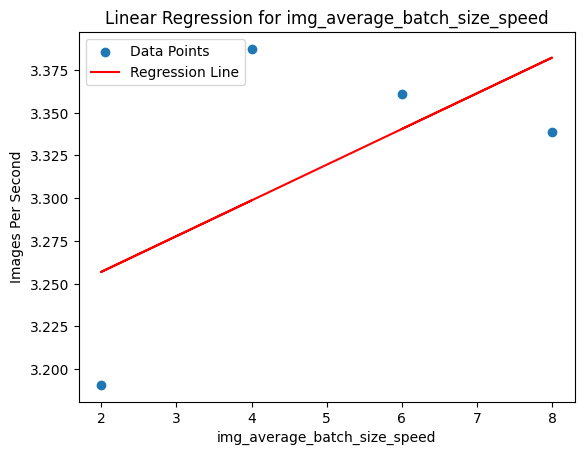


Parameter: img_average_batch_number_speed
Regression Coefficient: -0.007791416331963853
Intercept: 3.378025643094847


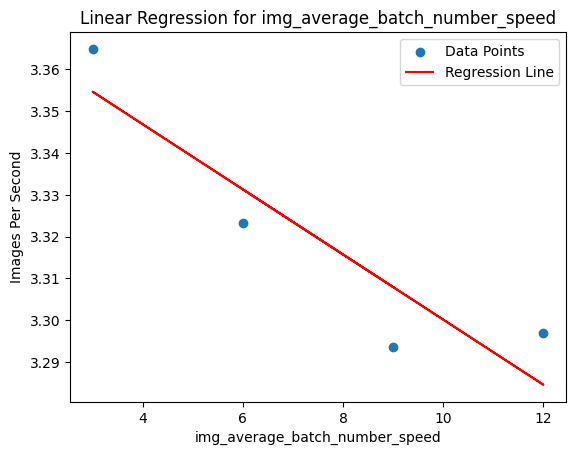


Parameter: img_average_repetition_speed
Regression Coefficient: -0.04840501075392807
Intercept: 3.4406025474899384


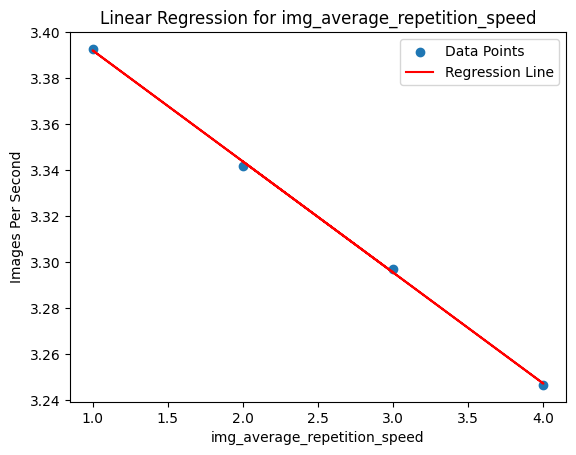


Parameter: img_average_dataset_size_speed
Regression Coefficient: 0.0007601438243554665
Intercept: 3.275423065788064


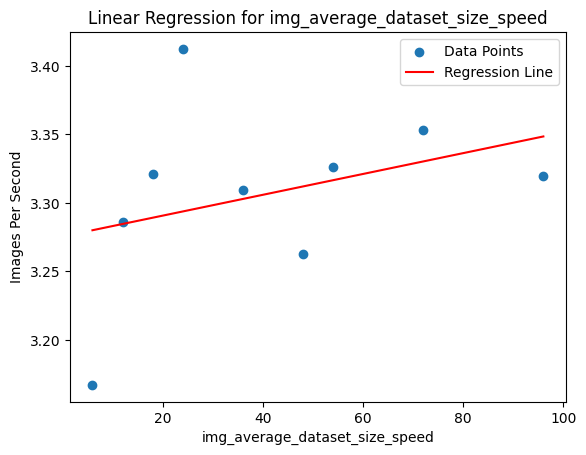


Parameter: raw_img_batch_size_results_rdd
Regression Coefficient: 0.020893520009728613
Intercept: 3.2151224205564755


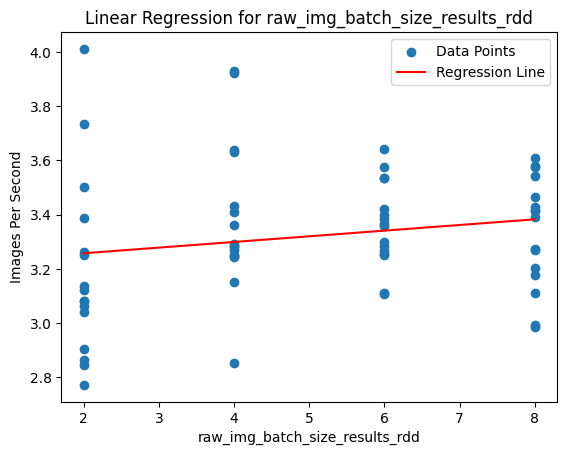


Parameter: raw_img_batch_number_results_rdd
Regression Coefficient: -0.007791416331963808
Intercept: 3.3780256430948468


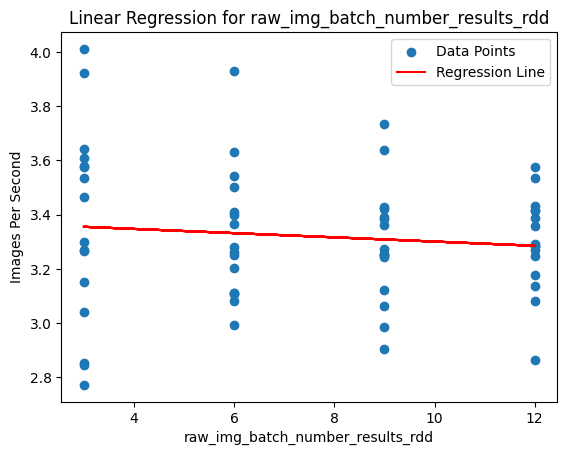


Parameter: raw_img_repetition_results_rdd
Regression Coefficient: -0.048405010753928134
Intercept: 3.440602547489939


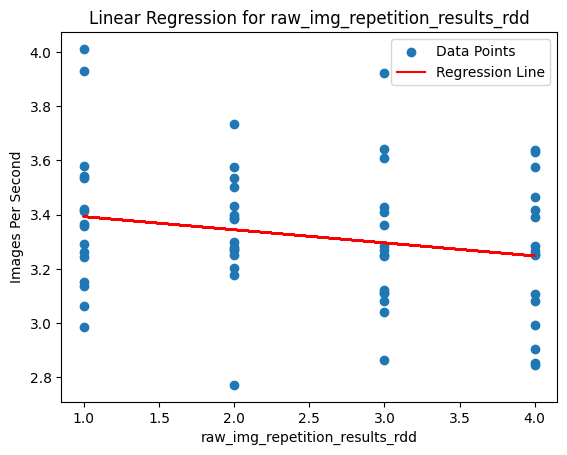


Parameter: raw_img_dataset_size_results_rdd
Regression Coefficient: 0.0003944708327434716
Intercept: 3.304797364377238


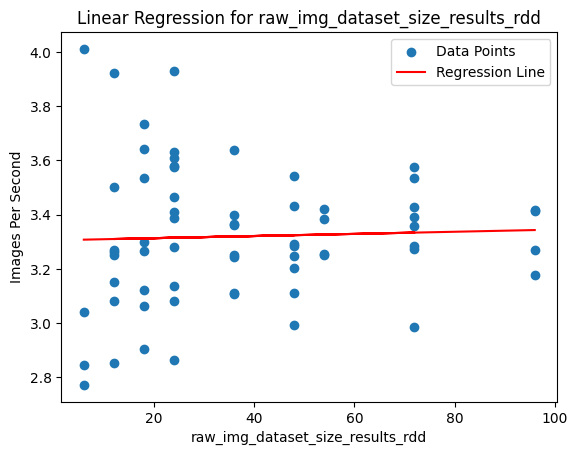

Results for TF mode:

Parameter: tf_average_batch_size_speed
Regression Coefficient: 0.00976629873269894
Intercept: 3.1649244638788714


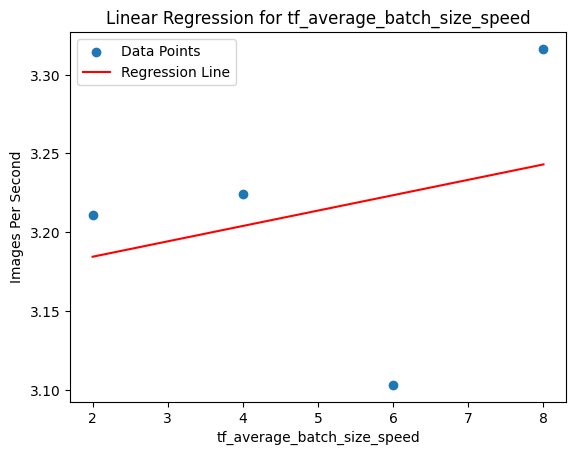


Parameter: tf_average_batch_number_speed
Regression Coefficient: -0.0032303202551130874
Intercept: 3.2379833594557144


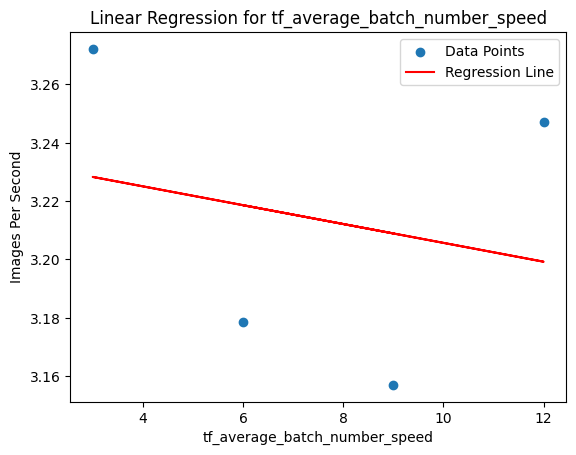


Parameter: tf_average_repetition_speed
Regression Coefficient: -0.003812193415756138
Intercept: 3.2232864410817568


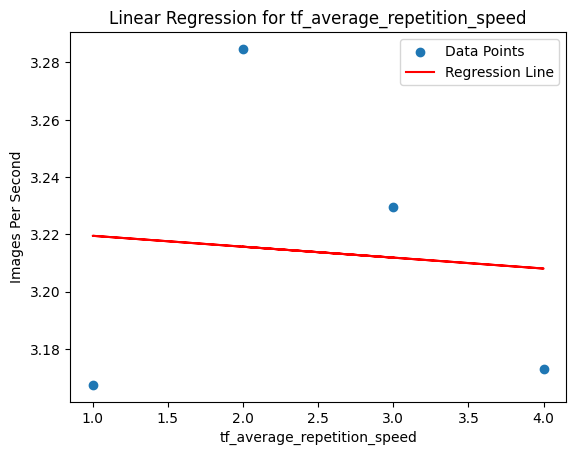


Parameter: tf_average_dataset_size_speed
Regression Coefficient: -0.00020949462012029182
Intercept: 3.229572311245217


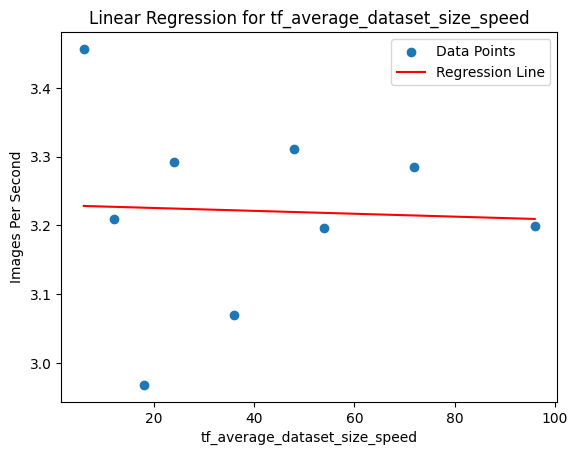


Parameter: raw_tf_batch_size_results_rdd
Regression Coefficient: 0.009766298732699012
Intercept: 3.164924463878871


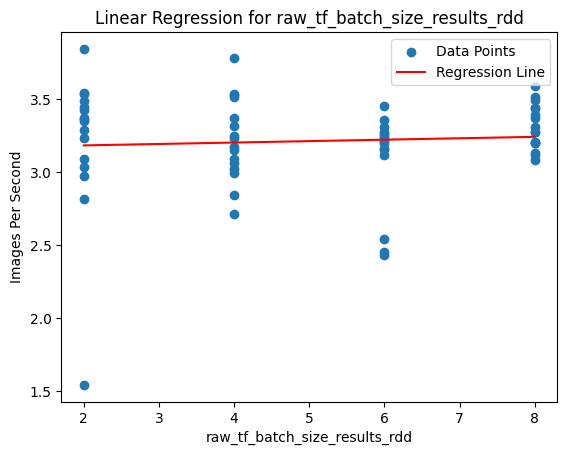


Parameter: raw_tf_batch_number_results_rdd
Regression Coefficient: -0.0032303202551131113
Intercept: 3.2379833594557144


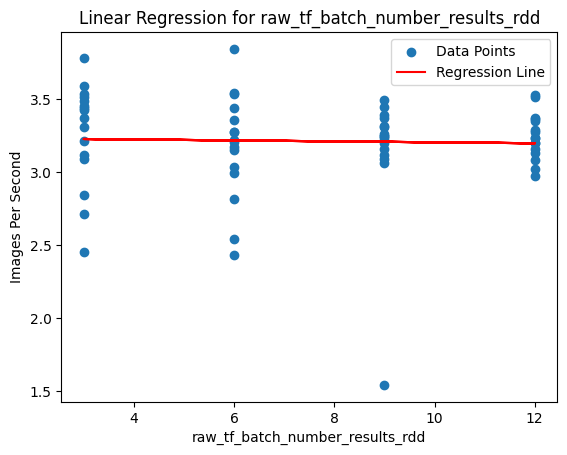


Parameter: raw_tf_repetition_results_rdd
Regression Coefficient: -0.003812193415756144
Intercept: 3.2232864410817568


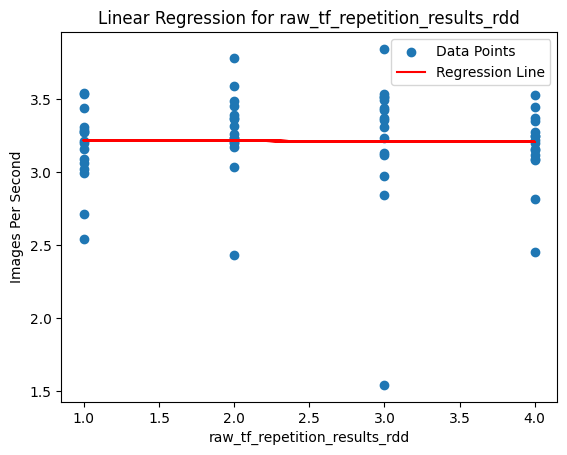


Parameter: raw_tf_dataset_size_results_rdd
Regression Coefficient: 0.0005231826412228078
Intercept: 3.194136608496511


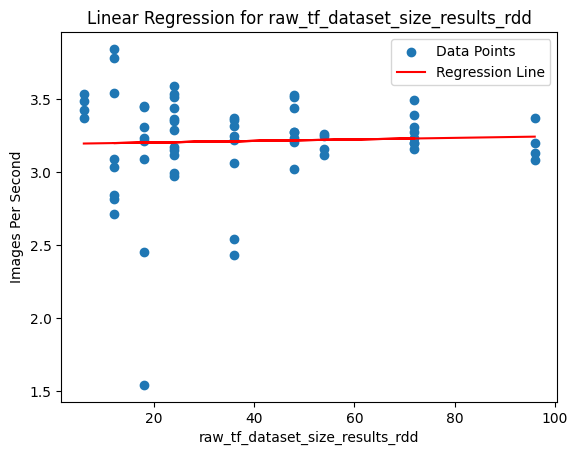

CPU times: user 5.21 s, sys: 1.52 s, total: 6.73 s
Wall time: 5.79 s


In [15]:
%%time
from sklearn.linear_model import LinearRegression

def perform_lr(parameter_data):
    X = np.array([entry[0] for entry in parameter_data]).reshape(-1, 1)
    y = np.array([entry[1] for entry in parameter_data])

    model = LinearRegression()
    model.fit(X, y)

    return model.coef_[0], model.intercept_

def draw_plot(parameter_data, parameter_name):
    X = np.array([entry[0] for entry in parameter_data])
    y = np.array([entry[1] for entry in parameter_data])

    coef, intercept = perform_lr(parameter_data)

    plt.scatter(X, y, label='Data Points')
    plt.plot(X, coef * X + intercept, color='red', label='Regression Line')
    plt.xlabel(parameter_name)
    plt.ylabel('Images Per Second')
    plt.title(f'Linear Regression for {parameter_name}')
    plt.legend()
    plt.show()


for mode, params in data.items():
    print(f"Results for {mode.upper()} mode:")
    for parameter_name, parameter_data in params.items():
        print(f"\nParameter: {parameter_name}")
        coef, intercept = perform_lr(parameter_data)
        print(f"Regression Coefficient: {coef}")
        print(f"Intercept: {intercept}")
        draw_plot(parameter_data, parameter_name)

# Section 3. Theoretical discussion

## Task 3: Discussion in context. (24%)

In this task we refer an idea that is introduced in this paper:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given compute task.

### 3a)	Contextualise

Relate the previous tasks and the results to this concept. (It is not necessary to work through the full details of the paper, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply to the task in this coursework? (12%)

### 3b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, stream) and discuss the general relationship with the concepts above. (12%)

Provide the answers to these questions in your report.


## Final cleanup

Once you have finshed the work, you can delete the buckets, to stop incurring cost that depletes your credit.

In [ ]:
!gsutil -m rm -r $BUCKET/* # Empty your bucket
!gsutil rb $BUCKET # delete the bucket